In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, cholesky

In [2]:
def generate_sparse_data(n=100, p=200, p0=10, sigma=1.0, seed=42):
    rng = np.random.default_rng(seed)
    
    # Design matrix
    X = rng.normal(0, 1, size=(n, p))
    X = (X - X.mean(axis=0)) / X.std(axis=0)  # standardize
    
    # True sparse coefficients
    beta_true = np.zeros(p)
    signal_idx = rng.choice(p, size=p0, replace=False)
    beta_true[signal_idx] = rng.normal(0, 3, size=p0)
    
    # Response
    y = X @ beta_true + rng.normal(0, sigma, size=n)
    y = y - y.mean()  # center
    
    return X, y, beta_true, signal_idx


In [3]:
def sample_inv_gamma(shape, scale):
    return 1.0 / np.random.gamma(shape, 1.0 / scale)


In [4]:
def horseshoe_regression(
    X, y,
    n_iter=3000,
    burn_in=1000
):
    n, p = X.shape
    
    # Initialization
    beta = np.zeros(p)
    sigma2 = 1.0
    
    lambda2 = np.ones(p)
    nu = np.ones(p)
    
    tau2 = 1.0
    xi = 1.0
    
    XtX = X.T @ X
    Xty = X.T @ y
    
    beta_samples = []
    kappa_samples = []
    
    for it in range(n_iter):
        
        # ---- Sample beta ----
        D_inv = np.diag(1.0 / (tau2 * lambda2))
        Sigma_beta = inv(XtX + D_inv)
        mu_beta = Sigma_beta @ Xty
        
        beta = mu_beta + cholesky(sigma2 * Sigma_beta) @ np.random.randn(p)
        
        # ---- Sample sigma^2 ----
        resid = y - X @ beta
        shape = (n + p) / 2
        scale = (resid @ resid + beta @ D_inv @ beta) / 2
        sigma2 = sample_inv_gamma(shape, scale)
        
        # ---- Sample lambda_j^2 ----
        for j in range(p):
            shape = 1.0
            scale = 1.0 / nu[j] + beta[j]**2 / (2 * sigma2 * tau2)
            lambda2[j] = sample_inv_gamma(shape, scale)
        
        # ---- Sample nu_j ----
        for j in range(p):
            nu[j] = sample_inv_gamma(1.0, 1.0 + 1.0 / lambda2[j])
        
        # ---- Sample tau^2 ----
        shape = (p + 1) / 2
        scale = 1.0 / xi + np.sum(beta**2 / lambda2) / (2 * sigma2)
        tau2 = sample_inv_gamma(shape, scale)
        
        # ---- Sample xi ----
        xi = sample_inv_gamma(1.0, 1.0 + 1.0 / tau2)
        
        # ---- Store samples ----
        if it >= burn_in:
            beta_samples.append(beta.copy())
            kappa = 1.0 / (1.0 + tau2 * lambda2)
            kappa_samples.append(kappa)
    
    return (
        np.array(beta_samples),
        np.array(kappa_samples),
    )


In [5]:
X, y, beta_true, signal_idx = generate_sparse_data()


In [7]:
X.shape

(100, 200)

In [10]:
beta_samples, kappa_samples = horseshoe_regression(X, y)
beta_mean = beta_samples.mean(axis=0)
kappa_mean = kappa_samples.mean(axis=0)

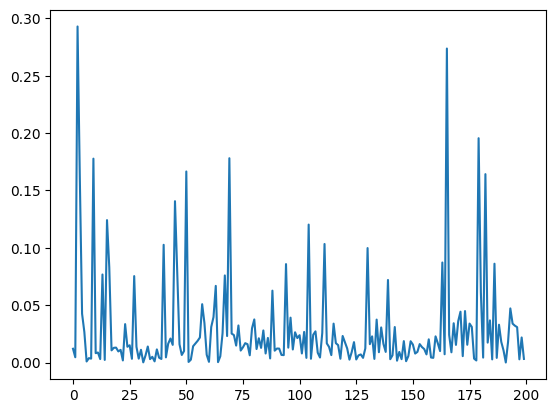

In [14]:
diff=abs(beta_true-beta_mean)
plt.plot(diff)
plt.show()

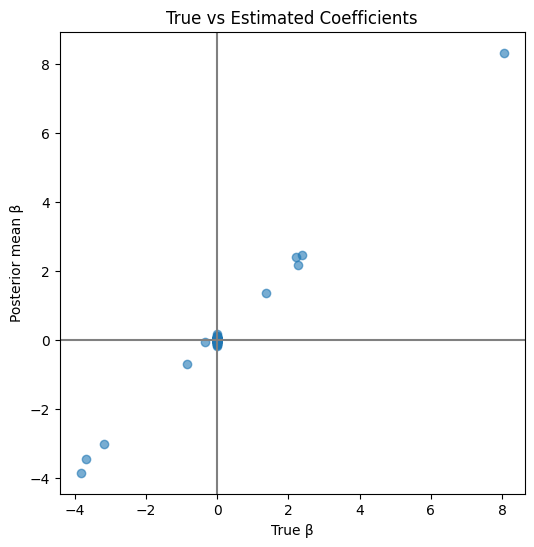

In [6]:
plt.figure(figsize=(6, 6))
plt.scatter(beta_true, beta_mean, alpha=0.6)
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.xlabel("True β")
plt.ylabel("Posterior mean β")
plt.title("True vs Estimated Coefficients")
plt.show()


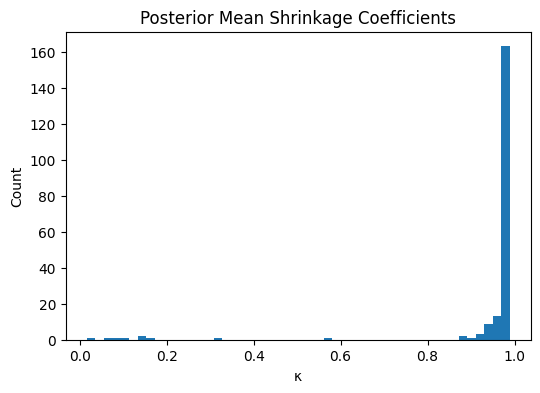

In [7]:
plt.figure(figsize=(6, 4))
plt.hist(kappa_mean, bins=50)
plt.xlabel("κ")
plt.ylabel("Count")
plt.title("Posterior Mean Shrinkage Coefficients")
plt.show()


In [13]:
import pandas as pd

In [15]:
kappa_mean.shape

(200,)

In [16]:
df=pd.DataFrame({'kappa':kappa_mean})
df.shape

(200, 1)

In [28]:
df[df['kappa']<=0.5].shape

(8, 1)

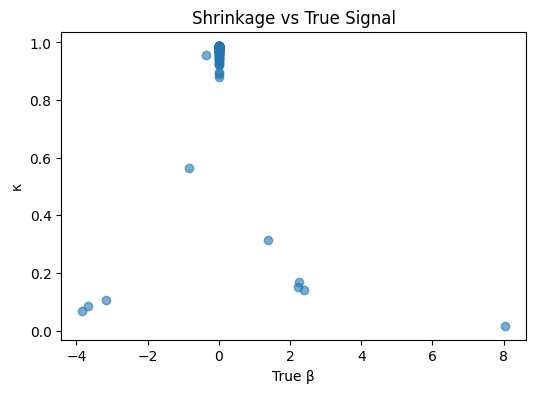

In [8]:
plt.figure(figsize=(6, 4))
plt.scatter(beta_true, kappa_mean, alpha=0.6)
plt.xlabel("True β")
plt.ylabel("κ")
plt.title("Shrinkage vs True Signal")
plt.show()


In [9]:
print("True non-zero indices:", sorted(signal_idx))
print("Top 10 largest |β̂| indices:",
      np.argsort(np.abs(beta_mean))[-10:])


True non-zero indices: [np.int64(2), np.int64(27), np.int64(50), np.int64(69), np.int64(70), np.int64(163), np.int64(165), np.int64(166), np.int64(179), np.int64(182)]
Top 10 largest |β̂| indices: [  9  50 166 163 182  27  69 179  70 165]
